## Voisey's Bay Intrusion, Labrador, Canada
- Data from Saumur and Cruden (2015) - On the emplacement of the Voisey’s Bay intrusion (Labrador, Canada)
- Roof data picked at random points on the geological map, and floor data picked from drill holes in cross sections

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loop library
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer 

ERROR: 2022-03-03 16:39:45,070: __init__.py:30 -- No meshio


In [2]:
lower_extent = [554800.0,6239650,-3000]
upper_extent = [561000,6243500,100]

#### 1. Load data

##### Input DataFrame description
> feature_name = name of the geological feature to be modelled. Faults 3 and 6 are the marginal faults that facilitated the emplacement of the inward-dipping outer sills

> (X, Y, Z) = data points location

> coord = structural frame coordinate

> val = values of the scalar field for interpolation of geological features

> (gx, gy, gz) = gradients of structural frame scalar fields

> intrusion_contact_type = roof/top or floor/base

> intrusion_side = TRUE if lateral contact, blank if not


In [3]:
model_data = pd.read_csv('C:/Users/falv0002/Documents/Repositories/LoopIntrusions/Paper1_Notebooks/Voiseys Bay Intrusion.csv')
intrusion_data = model_data[model_data['feature_name'] == 'Voiseys Bay Intrusion'].copy()

In [4]:
model_data.head()

,feature_name,X,Y,Z,coord,val,gx,gy,gz,intrusion_contact_type,intrusion_side
0,Voiseys Bay Intrusion,555881.007,6243254.351,0.0,NaN,NaN,NaN,NaN,NaN,roof,True
1,Voiseys Bay Intrusion,555987.860,6243137.224,0.0,NaN,NaN,NaN,NaN,NaN,roof,True
2,Voiseys Bay Intrusion,556082.384,6242900.915,0.0,NaN,NaN,NaN,NaN,NaN,roof,True
3,Voiseys Bay Intrusion,556193.347,6242816.665,0.0,NaN,NaN,NaN,NaN,NaN,roof,True
4,Voiseys Bay Intrusion,556881.727,6242798.171,0.0,NaN,NaN,NaN,NaN,NaN,roof,True


#### 2. Define conceptual model function to constraint lateral and vertical extent

These conceptual models are used to constraint the geometry of the intrusion lateral and vertical extent.

In [5]:
# Conceptual models

def ellipse_function(
    lateral_contact_data, minP=None, maxP=None, minS=None, maxS=None
):

    if minP == None:
        minP = lateral_contact_data["coord1"].min()
    if maxP == None:
        maxP = lateral_contact_data["coord1"].max()
    if minS == None:
        minS = lateral_contact_data["coord2"].abs().min()
    if maxS == None:
        maxS = lateral_contact_data["coord2"].max()

    a = (maxP - minP) / 2
    b = (maxS - minS) / 2

    po = minP + (maxP - minP) / 2

    p_locations = lateral_contact_data.loc[:, "coord1"].copy().to_numpy()

    s = np.zeros([len(p_locations), 2])
    
    s[np.logical_and(p_locations>minP, p_locations<maxP),0] =  b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 
    s[np.logical_and(p_locations>minP, p_locations<maxP),1] =  -b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 
    
    return s

def obliquecone_function(othercontact_data, mean_growth=None, minP=None, maxP=None, minS=None, maxS=None, vertex=None): 
    # import math
    
    ps_locations = othercontact_data.loc[:,['coord1','coord2']].to_numpy()
    
    minP=1.5*minP
    maxP=1.5*maxP 
    minS=1.5*minS
    maxS=1.5*maxS
    
    a = (maxP-minP)/2 #semi-major axis
    b = (maxS-minS)/2 #semi-minor axis
    a2 = pow(a,2)
    b2 = pow(b,2)
    
    po = minP + a #p coordinate of ellipsis centre
    so = minS + b #s coordinate of ellipsis centre
    
    alpha = vertex[0] #p coordinate of vertex
    beta = vertex[2] #g coordinate of vertex
    gamma = vertex[1] #l coordinate of vertex
    
    growth = np.zeros([len(ps_locations),2]) #container for results
    
    p = ps_locations[:,0]
    s = ps_locations[:,1]
        
    A = alpha - po
    B = beta*(p[:] - alpha)
    C = gamma - so
    D = beta*(s[:] - gamma)
        
    F = pow(A*b,2) + pow(C*a,2) - a2*b2
    G = 2*(B*A*b2 + C*D*a2)
    H = pow(b*B,2) + pow(a*D,2)
        
    constant_g2 = F
    constant_g = -2*F*beta - G
    constant_1 = F*pow(beta,2) + G*beta + H
        
    discriminant = pow(constant_g,2) - 4*constant_g2*constant_1
    discriminant[discriminant < 0] = 0

    growth[:,0] = -(constant_g + np.sqrt(discriminant))/(2*constant_g2)
    growth[:,1] = -(constant_g - np.sqrt(discriminant))/(2*constant_g2)
        
    return growth

#### 3. Create geological model

##### The ``create_and_add_intrusion`` function of the ``GeologicalModel`` class creates an ``IntrusionFeature`` in two steps: 

**1. Create the intrusion builder:**

IntrusionBuilder creates the intrusion structural frame using the ``StructuralFrame class``.
This object is a culvilinear coordinate system of the intrusion body used to constrained the extent of the intrusion.
The intrusion frame is constrained using the intrusion network points - set of points that represents the location of the intrusion roof (or floor) contact - and propagation and inflation measurements.

**2. Create the intrusion feature:**

Simulation of thresholds distances (along structural frame coordinates) to constrain the intrusion lateral and vertical extent.** 
Distances along axis L are simulated to constraint the intrusion lateral extent and distances along axis G are simulated to constained its vertical extent. 
Simulated values are restricted using conceptual geometrical models representing the expected shape of the intrusion.

This step is performed using the GeostatPy library (https://pypi.org/project/geostatspy/), and its implementation of sequential gaussian simulation. 

##### The input parameters for the ``create_and_add_intrusion`` function are: 

> intrusion_name :  string, name of intrusion feature in model data

> intrusion_frame_name :  string, name of intrusion frame in model data
        
> intrusion_lateral_extent_model = function, geometrical conceptual model for simulation of lateral extent
        
> intrusion_vertical_extent_model = function, geometrical conceptual model for simulation of vertical extent
        
> intrusion_network_parameters : dictionary, optional. Keys:

        > contact : string, contact of the intrusion to be used to create the network (roof or floor, default: floor)
            
        > type : string, type of algorithm to create the intrusion network (interpolated or shortest path, default: interpolated)
                Shortest path is recommended when intrusion contact is not well constrained
        
        > contacts_anisotropies : list of series-type features involved in intrusion emplacement
        
        > structures_anisotropies : list of fault-type features involved in intrusion emplacement
        
        > sequence_anisotropies : list of anisotropies to look for the shortest path. It could be only starting and end point.
        
        > shortest_path_axis : string (X, Y or Z), shortest path is look within sections along this axis. 
                If faults presents, it is recommended this inext being orthogonal to the fault strike.

        > number_contacts : number of stratigraphic contacts from the same series  

        > delta_c, delta_f : deault values = 1. Used to identify the anisotropies using indicator functions. 
                Each anisotropy is characterized by an unknown isovalue of a scalar field *f*. 
                Observation points are evaluated on each scalar field, and we used the mean and standard deviation to approximate this isovalue. 
                An anisotropy is indicated in point (x,y,z) if 

                                    *(mean - std*delta)<=f(x,y,z)<=(mean + std*delta)*
        
> lateral_extent_sgs_parameters and vertical_extent_sgs_parameters = dictionary, optional, parameters for sequential gaussian simulation of lateral/vertical extent. 


        > tmin, tmax : all values, regardless of which variable, strictly less than tmin and greater than or equal to tmax are ignored.

                tmin = -9999 and tmax = 9999

        > itrans : 0 - no transformation requiered, data already nscored / 1 - for transformation.

                itrans = 1

        > ktype : type of interpolation, 0 for simple kriging - 1 for ordinary kriging.

                ktype = 0

        > nx, ny : Numbers of blocks. Grid node indices ix, iy increase from 1 to nx, ny respectively (in the positive x,y direction).

                nx, ny = nsteps[:,1]

        > xmn, ymn :  Centre of the first block (xmn,ymn).

                xmn, ymn = minimum coordinate p and l within the model boundaries

        > xsiz, ysiz : Size of blocks.

                xsiz, ysiz = model boundaries/nteps        

        > zmin, zmax, zmin2, zmax2 : The minimum and maximum allowable data values simulation.

                zmin, zmax = min and max of the input data for simulations

        > nxdis, nydis : Number of discretization points for a block. If both nxdis and nydis are set to 1, then point kriging is performed. 

                nxdis, nydis = 1

        > ndmin, ndmax : The minimum and maximum number of original data that should be used to simulate a grid node. If there are fewer than ndmin data points, the node is not simulated.

                ndmin = 0
                ndmax = 3

        > radius : The maximum isotropic search radius.

                radius = 500

        The default variogram is an isotropic variogram with infinite range, and no nugget effect. 

        > nug: nugget effect

                nug = 0

        > nst: number of nested structures (up to 2)

                nst = 1

        > it1, it2: nested structure 1,2 type (1 - spherical, 2 - exponential, 3 - Gaussian)

                it1 = 1, it2 = None

        > cc1,cc2: contribution to the sill of nested structure 1,2

                cc1 = 1, cc2 = None

        > azi1, azi2: azimuth of nested structure 1,2

                azi1 = 90, azi2 = None

        > hmaj1, hmin1, hmaj2, hmin2 : range of structure 1 in the major (hmaj1) and minor (hmin1) direction

                hmaj1, hmin1 = 999999, hmaj2, hmin2 = None


In [6]:
# Create Geological Model
model = GeologicalModel(lower_extent,upper_extent)
model.nsteps = [50,50,50]
model.data = model_data

conformable_feature = model.create_and_add_foliation('stratigraphy', nelements = 3000, solver = 'lu', interpolatortype = 'FDI')


thicknes_simulation_parameters = {'radius':1000} # modify search radious for simulation of vertical extent
width_simulation_parameters = {'hmaj1':1000, 'hmin1': 1000, 'radius' : 10000} 

intrusion_network_parameters = {'type' : 'interpolated' , 'contact' :'roof'}
VoiseysBay_Intrusion = model.create_and_add_intrusion('Voiseys Bay Intrusion', intrusion_frame_name = 'Voiseys Bay Intrusion Frame',
                                                      intrusion_network_parameters = intrusion_network_parameters,
                                                      intrusion_lateral_extent_model = ellipse_function,
                                                      intrusion_vertical_extent_model = obliquecone_function,
                                                      vertical_extent_sgs_parameters = thicknes_simulation_parameters,
                                                      lateral_extent_sgs_parameters = width_simulation_parameters)


 Data for SGSIM: Number of acceptable data     = 16
                 Number trimmed                = 0
                 Weighted Average              = -434.5167
                 Weighted Variance             = 146209.1628
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9237
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 60
   currently on node 120
   currently on node 180
   currently on node 240
   currently on node 300
   currently on node 360
   currently on node 420
   currently on node 480
   currently on node 540
Reassigning data to nodes

 Realization 0: number   = 600
                                   mean     = 0.025 (close to 0.0?)
                                   variance = 1.0465 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 13
                 Number trimmed                = 0
             

#### 4. Visualization of lateral and vertical extent simulation, along the intrusion frame coordinates

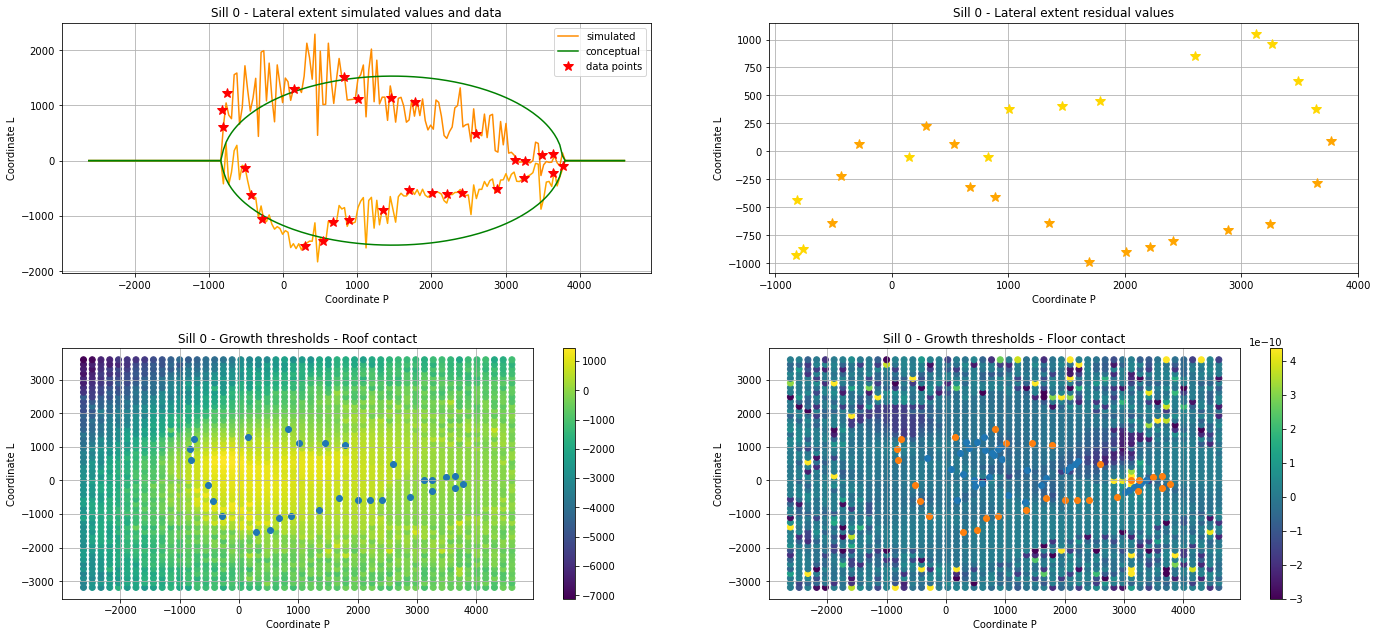

In [7]:
intrusion = VoiseysBay_Intrusion

plt.subplot(221) # Lateral extent simulated values and data     
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'min_l_threshold'],"-",c='orange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'max_l_threshold'],"-", label = 'simulated', c='darkorange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_minl'],"-", c='green', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_maxl'],"-",  label = 'conceptual', c='green', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'coord2'],"*",  label = 'data points', c='red', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'coord2'],"*", c='red', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent simulated values and data')
plt.legend()
plt.grid(True)


plt.subplot(222) # Residual values  
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'l_residual'],"*",  label = 'sides1', c='orange', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'l_residual'],"*",  label = 'sides1', c='gold', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent residual values')
plt.grid(True)

plt.subplot(223) # Vertical extent     
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_maximum'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Roof contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplot(224)
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_minimum'])
plt.scatter(intrusion.vertical_sgs_input_data[0].loc[:,'coord1'],intrusion.vertical_sgs_input_data[0].loc[:,'coord2'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Floor contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=2, wspace=0.2, hspace=0.3)
plt.show()

##### 4.1 To set up new simulation parameters and run a new simulation:

**Lateral extent:**

> IntrusionFeature.set_l_sgs_GSLIBparameters(new_sgs_parameters)
    
> IntrusionFeature.make_l_sgs_variogram(new_sgs_parameters)

> IntrusionFeature.simulate_lateral_thresholds()


**Vertical extent:**

> IntrusionFeature.set_g_sgs_GSLIBparameters(new_sgs_parameters)
    
> IntrusionFeature.make_g_sgs_variogram(new_sgs_parameters)

> IntrusionFeature.simulate_vertical_thresholds()


In this example, we modified the range of the variogram, to smooth the lateral contact. 


 Data for SGSIM: Number of acceptable data     = 16
                 Number trimmed                = 0
                 Weighted Average              = -434.5167
                 Weighted Variance             = 146209.1628
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9237
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 60
   currently on node 120
   currently on node 180
   currently on node 240
   currently on node 300
   currently on node 360
   currently on node 420
   currently on node 480
   currently on node 540
Reassigning data to nodes

 Realization 0: number   = 600
                                   mean     = 0.0663 (close to 0.0?)
                                   variance = 0.9398 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 13
                 Number trimmed                = 0
            

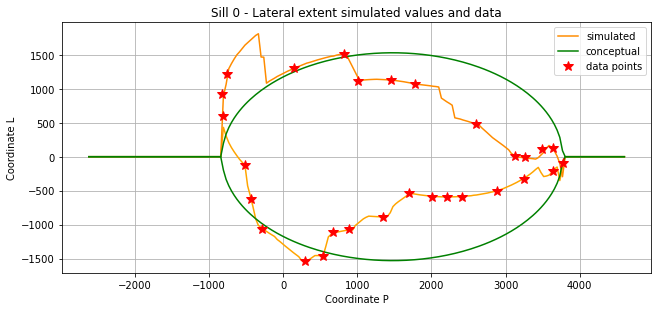

In [8]:
new_sgs_parameters = {'hmaj1':1e8, 'hmin1': 1e8} # increase range of variogram

VoiseysBay_Intrusion.set_l_sgs_GSLIBparameters(new_sgs_parameters)
    
VoiseysBay_Intrusion.make_l_sgs_variogram(new_sgs_parameters)

VoiseysBay_Intrusion.simulate_lateral_thresholds()

plt.subplot(221) # Lateral extent simulated values and data     
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'min_l_threshold'],"-",c='orange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'max_l_threshold'],"-", label = 'simulated', c='darkorange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_minl'],"-", c='green', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_maxl'],"-",  label = 'conceptual', c='green', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'coord2'],"*",  label = 'data points', c='red', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'coord2'],"*", c='red', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent simulated values and data')
plt.legend()
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=2, wspace=0.2, hspace=0.3)
plt.show()

In [9]:
# improve model resolution 
model.nsteps = [60,60,60]

In [10]:
viewer = LavaVuModelViewer(model, background='white')
viewer.add_isosurface(conformable_feature['feature'], nslices = 6, colour = 'grey')

viewer.add_points(model_data.loc[:,['X','Y','Z']].to_numpy(), name = 'model input data', pointsize = 5)
viewer.add_points(intrusion_data.loc[:,['X','Y','Z']].to_numpy(), name = 'intrusion data', pointsize = 10)

viewer.add_isosurface(VoiseysBay_Intrusion, isovalue = 0, colour = 'red')

viewer.interactive()

Assigning lateral thresholds
Assigning vertical thresholds


c:\users\falv0002\documents\repositories\loopstructural\LoopStructural\modelling\intrusions\intrusion_feature.py:948: RuntimeWarning: divide by zero encountered in true_divide
  si_s / si_s.min(axis=1)[:, None], 2
c:\users\falv0002\documents\repositories\loopstructural\LoopStructural\modelling\intrusions\intrusion_feature.py:948: RuntimeWarning: invalid value encountered in true_divide
  si_s / si_s.min(axis=1)[:, None], 2
c:\users\falv0002\documents\repositories\loopstructural\LoopStructural\modelling\intrusions\intrusion_feature.py:951: RuntimeWarning: divide by zero encountered in true_divide
  pi_p / pi_p.min(axis=1)[:, None], 2
c:\users\falv0002\documents\repositories\loopstructural\LoopStructural\modelling\intrusions\intrusion_feature.py:951: RuntimeWarning: invalid value encountered in true_divide
  pi_p / pi_p.min(axis=1)[:, None], 2


#### Other features

In [11]:
intrusion_frame = VoiseysBay_Intrusion.intrusion_frame
intrusion_network = VoiseysBay_Intrusion.builder.intrusion_network_points

In [12]:
viewer2 = LavaVuModelViewer(model, background='white')

viewer2.add_points(model.rescale(intrusion_network[:,:3]), name ='Voiseys Bay Intrusion Network', colour = 'blue', pointsize = 6)

viewer2.add_isosurface(intrusion_frame[0], isovalue = 0, colour = 'darkred')
viewer2.add_isosurface(intrusion_frame[1], isovalue =0, colour = 'darkgreen')
viewer2.add_isosurface(intrusion_frame[2], isovalue = 0, colour = 'blue')
viewer2.add_data(intrusion_frame[0])
viewer2.add_data(intrusion_frame[1])
viewer2.interactive()